In [1]:
# -*- coding: utf-8 -*-

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
from scipy.spatial import distance as dist
import glob
sns.set_style('ticks')
import multiprocessing as mp
%matplotlib inline
cv2.setNumThreads(0)


In [2]:
def add_border(tag, tag_shape, white_width = 1, black_width = 2):
    
    """Add black and white border to barcode tag.
        
        Parameters
        ----------
        tag : 1-D array_like
            Flattened barcode tag.
        tag_shape : tuple of int
            Shape of the barcode tag without a border.
        white_width : int
            Width of white border.
        black_width : int
            Width of black border.
            
        Returns
        -------
        bordered_tag : 1-D array
            Returns tag with border added flattened to 1-D array.
        """
    
    tag = np.asarray(tag)
    tag = tag.reshape(tag_shape)

    black_border = np.zeros((tag_shape[0]+(2*white_width)+(2*black_width),tag_shape[1]+(2*white_width)+(2*black_width)))
    white_border = np.ones((tag_shape[0]+(2*white_width),tag_shape[1]+(2*white_width)))
    
    white_border[white_width:tag_shape[0]+white_width,white_width:tag_shape[1]+white_width] = tag
    black_border[black_width:tag_shape[0]+(2*white_width)+black_width, black_width:tag_shape[1]+(2*white_width)+black_width] = white_border

    tag = black_border
    bordered_tag = tag.reshape((1,tag.shape[0]*tag.shape[1]))
    tag_shape = black_border.shape
    return  tag_shape, bordered_tag

In [3]:
master_list = np.load("/Users/Jake/Google Drive/Gustavo_Finch_Videos/master_list.npy")
master_list = master_list[:800]
master_list.shape

(800, 25)

In [4]:
barcode_size = (7,7)
barcodes = []
for barcode in master_list:
    tag_shape, barcode = add_border(barcode, (5,5), white_width = 1, black_width = 0)
    barcode = barcode.reshape(tag_shape)
    barcode = cv2.resize(barcode, barcode_size, interpolation = cv2.INTER_AREA)
    #plt.imshow(barcode, cmap = 'gray', interpolation = 'None')
    #plt.show()
    barcode = barcode.flatten()
    barcodes.append(barcode)
barcodes = np.array(barcodes)
#barcodes[barcodes == 0] = 0
#barcodes[barcodes == 1] = 255
barcodes

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [5]:
ID_list = []
for i in range(len(barcodes)/4):
    ID = [i,i,i,i]
    ID_list.append(ID)
ID_array = np.array(ID_list) + 1
IDs = ID_array.flatten()
IDs

array([  1,   1,   1,   1,   2,   2,   2,   2,   3,   3,   3,   3,   4,
         4,   4,   4,   5,   5,   5,   5,   6,   6,   6,   6,   7,   7,
         7,   7,   8,   8,   8,   8,   9,   9,   9,   9,  10,  10,  10,
        10,  11,  11,  11,  11,  12,  12,  12,  12,  13,  13,  13,  13,
        14,  14,  14,  14,  15,  15,  15,  15,  16,  16,  16,  16,  17,
        17,  17,  17,  18,  18,  18,  18,  19,  19,  19,  19,  20,  20,
        20,  20,  21,  21,  21,  21,  22,  22,  22,  22,  23,  23,  23,
        23,  24,  24,  24,  24,  25,  25,  25,  25,  26,  26,  26,  26,
        27,  27,  27,  27,  28,  28,  28,  28,  29,  29,  29,  29,  30,
        30,  30,  30,  31,  31,  31,  31,  32,  32,  32,  32,  33,  33,
        33,  33,  34,  34,  34,  34,  35,  35,  35,  35,  36,  36,  36,
        36,  37,  37,  37,  37,  38,  38,  38,  38,  39,  39,  39,  39,
        40,  40,  40,  40,  41,  41,  41,  41,  42,  42,  42,  42,  43,
        43,  43,  43,  44,  44,  44,  44,  45,  45,  45,  45,  4

In [6]:
def crop(src, pt1, pt2):
    
    """ Returns a cropped version of src """
    
    cropped = src[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    
    return cropped

def distance(vector):
 
    """ Return distance of vector """

    return np.sqrt(np.sum(np.square(vector)))

def order_points(pts):
    # sort the points based on their x-coordinates
    sorted_ = pts[np.argsort(pts[:, 0]), :]
 
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    left = sorted_[:2, :]
    right = sorted_[2:, :]
 
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    left = left[np.argsort(left[:, 1]), :]
    (tl, bl) = left
 
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], right, "euclidean")[0]
    (br, tr) = right[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = np.subtract(A, A.mean(1)[:,None])
    B_mB = np.subtract(B, B.mean(1)[:,None])

    # Sum of squares across rows
    ssA = np.square(A_mA).sum(1)
    ssB = np.square(B_mB).sum(1)

    # Finally get corr coeff
    return np.divide(np.dot(A_mA,B_mB.T), np.sqrt(np.dot(ssA[:,None],ssB[None])))

def unit_vector(vector):
	
	""" Returns the unit vector of the vector.  """
	
	return np.divide(vector, np.linalg.norm(vector))

def angle(v1, v2, degrees = True):
	
	"""Returns the angle between vectors 'v1' and 'v2'.
		
		Parameters
		----------
		v1 : 1-D array_like
			N-dimensional vector.
		v2 : 1-D array_like
			N-dimensional vector.
		degrees : bool, default = True
			Return angle in degrees.
			
		Returns
		-------
		angle : float
			Angle between v1 and v2.
		
		"""
	
	v1_u = unit_vector(v1)
	v2_u = unit_vector(v2)
	angle = np.arccos(np.dot(v1_u, v2_u))
	if np.isnan(angle):
		if (v1_u == v2_u).all():
			return 0.0
		else:
			return np.pi
	if degrees == True:
		angle = np.degrees(angle)
	return angle

def get_grayscale(color_image, channel = None):

	""" Returns single-channel grayscale image from 3-channel BGR color image.

		Parameters
		----------
		color_image : (MxNx3) numpy array
			3-channel BGR-format color image as a numpy array
		channel : 'blue', 'green', 'red', 'none', or None, default = None
			The color channel to use for producing the grayscale image.
			None and 'none' default to cv2.cvtColor() using cv2.COLOR_BGR2GRAY. 
			Channels 'blue', 'green', and 'red' use the respective color channel as the grayscale image. 
			Channel 'green' typically provides the lowest noise, but this will depend on the lighting in the image.
			
		Returns
		-------
		gray_image : (MxNx1) numpy array
			Single-channel grayscale image as a numpy array.

	"""
	assert channel in ['blue', 'green', 'red', 'none', None], "channel must be 'blue', 'green', 'red', 'none', or None"
	assert type(color_image) == np.ndarray, "image must be a numpy array"

	image_shape = color_image.shape
	assert len(image_shape) == 3, "image must be color"
	assert color_image.shape[2] == 3, "image must have 3 color channels"
	assert color_image.dtype == np.uint8, "image array must be dtype np.uint8"

	if channel == 'blue':
		gray_image, _, _ = cv2.split(color_image)
	if channel == 'green':
			_, gray_image, _ = cv2.split(color_image)
	if channel == 'red':
		_, _, gray_image = cv2.split(color_image)
	if channel == None or channel == 'none':
		gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

	return gray_image

def get_threshold(gray_image, block_size = 1001, C = 2):

	""" Returns binarized thresholded image from single-channel grayscale image.

		Parameters
		----------
		gray_image : (MxNx1) numpy array
			Single-channel grayscale image as a numpy array
		block_size : int, default = 1001
			Odd value integer. Size of the local neighborhood for adaptive thresholding.
		C : default = 2
			Constant subtracted from the mean. Normally, it is positive but may be zero or negative as well. 
			The threshold value T(x,y) is a mean of the block_size x block_size neighborhood of (x, y) minus C.

		Returns
		-------
		threshold_image : (MxNx1) numpy array
			Binarized (0, 255) image as a numpy array.

	"""

	assert block_size % 2 == 1, "block_size must be an odd value"
	assert type(gray_image) == np.ndarray, "image must be a numpy array"

	assert len(gray_image.shape) == 2, "image must be grayscale"
	assert gray_image.dtype == np.uint8, "image array must be dtype np.uint8"

	threshold_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)

	return threshold_image

def get_contours(threshold_image):

	""" Returns a list of contours from a binarized thresholded image.

		Parameters
		----------
		threshold_image : (MxNx1) numpy array
			Binarized threshold image as a numpy array

		Returns
		-------
		contours : list
			List of contours extracted from threshold_image.

	"""
	assert len(set([0, 255]) - set(np.unique(threshold_image))) == 0, "image must be binarized to (0, 255)"

	_, contours, _ = cv2.findContours(threshold_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

	return contours


In [7]:
finch_videos = glob.glob("/Users/Jake/Google Drive/Gustavo_Finch_Videos/*")
finch_videos

['/Users/Jake/Google Drive/Gustavo_Finch_Videos/GP049996.MP4',
 '/Users/Jake/Google Drive/Gustavo_Finch_Videos/master_list.npy',
 '/Users/Jake/Google Drive/Gustavo_Finch_Videos/printed_barcodes.pdf',
 '/Users/Jake/Google Drive/Gustavo_Finch_Videos/printed_barcodes.png',
 '/Users/Jake/Google Drive/Gustavo_Finch_Videos/printed_barcodes_large.pdf',
 '/Users/Jake/Google Drive/Gustavo_Finch_Videos/ZebraFinch_4Aug.MP4']

In [10]:
def job(image):
        
    n_tags = 0
    pixel_values = []
    warped_list = []

    #image = crop(image, pt1, pt2)
    #cropped = cv2.resize(cropped, (0,0), None, fx = 0.33, fy = 0.33, interpolation = cv2.INTER_LINEAR)

    #image = cv2.resize(image, (0,0), None, fx = 3, fy = 3, interpolation = cv2.INTER_AREA)


    display_img = image.copy()

    #_, gray, _ = cv2.split(image)
    gray = get_grayscale(image, channel = 'green')
    #gray = cv2.GaussianBlur(gray, (3,3), 1)
    #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 1001, 0)
    thresh = get_threshold(gray, block_size = 1001, C = 0)
    #ret, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    #contour_image, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = get_contours(thresh)
    #cv2.drawContours(display_img, contours, -1, (0,0,255), 3)
    edge_thresh = 1
    image_shape = image.shape
    maxx_thresh = image_shape[1] - edge_thresh
    maxy_thresh = image_shape[0] - edge_thresh

    for cnt in contours:

        cnt_shape = cnt.shape

        if cnt_shape[0] >= 4:

            area = cv2.contourArea(cnt, True)

            if -100 > area > -800:

                cnt_reshape = cnt.reshape((cnt_shape[0], cnt_shape[2]))
                cnt_x = cnt_reshape[:,0]
                cnt_y = cnt_reshape[:,1]
                flat = cnt.flatten()
                edge_zero = np.sum(flat <= edge_thresh)
                edge_maxx = np.sum(cnt_x >= maxx_thresh)
                edge_maxy = np.sum(cnt_y >= maxy_thresh)

                if edge_zero == 0 and edge_maxx == 0 and edge_maxy == 0:

                    peri_cnt = cv2.arcLength(cnt, True)

                    approx = cv2.approxPolyDP(cnt, 0.03 * peri_cnt, True)

                    #cv2.drawContours(display_img, [approx], -1, (0,0,255), 3)

                    poly_area = cv2.contourArea(approx, True)

                    if len(approx) == 4 and -100 > poly_area > -800 and cv2.isContourConvex(approx) and 10 < peri_cnt < 200:
                        peri_approx = cv2.arcLength(approx, True)

                        peri_ratio = peri_cnt/peri_approx
                        periarea = peri_cnt/area

                        cv2.drawContours(display_img, [cnt], -1, (0,0,255), 2)

                        if -0.5 < periarea <= 0:

                            cv2.drawContours(display_img, [cnt], -1, (0,255,255), 2)

                            peri_approx = cv2.arcLength(approx, True)

                            cnt_shape = approx.shape
                            pts = approx.reshape((cnt_shape[0], cnt_shape[-1]))
                            
                            pts = order_points(pts)
                            (tl, tr, br, bl) = pts

                            # compute the perspective transform matrix and then apply it
                            M = cv2.getPerspectiveTransform(pts, dst)
                            warped = cv2.warpPerspective(gray, M, (maxSide, maxSide), borderValue = 255)

                            warped_list.append(warped)
                            resize_warp = cv2.resize(warped, barcode_size, interpolation = cv2.INTER_AREA)

                            pixel_values.append(resize_warp)

                            correlation = corr2_coeff(barcodes, resize_warp.reshape((1,flat_len)))
                            best_value = np.max(correlation)

                            best_values.append(best_value)
                            area_list.append(area)
                            peri_list.append(peri_cnt)
                            periratio_list.append(peri_ratio)
                            periarea_list.append(peri_cnt/area)

                            if best_value > 0.8:

                                #best_values.append(best_value)
                                #area_list.append(area)
                                best_index = np.argmax(correlation)

                                ID = IDs[best_index]
                                ID_list.append(ID)
                                centroid = pts.mean(0)
                                y_offset = 0
                                x_offset = 0
                                bottom_centroid = tuple((centroid + np.array([x_offset,-1*y_offset])).astype(int))
                                top_centroid = tuple((centroid + np.array([x_offset,y_offset])).astype(int))
                                mid_centroid = tuple((centroid + np.array([x_offset,0])).astype(int))
                                centroid = tuple(centroid)

                                rotate_test = best_index % 4

                                if rotate_test == 3:
                                    edge = tuple(np.mean([tl, tr], axis = 0))
                                if rotate_test == 0:
                                    edge = tuple(np.mean([tl, bl], axis = 0))
                                if rotate_test == 1:
                                    edge = tuple(np.mean([br, bl], axis = 0))
                                if rotate_test == 2:
                                    edge = tuple(np.mean([br, tr], axis = 0))
                                cv2.drawContours(display_img, [approx], -1, (0,255,0), 2)

                                #cv2.circle(display_img,tuple(pts[0]), rad, (255,0,0), -1)
                                #cv2.circle(display_img,tuple(pts[1]), rad, (0,255,0), -1)
                                #cv2.circle(display_img,tuple(pts[2]), rad, (0,0,255), -1)
                                #cv2.circle(display_img,tuple(pts[3]), rad, (255,0,255), -1)

                                #cv2.circle(display_img,centroid, rad, (0,255,0), -1)

                                vector = np.subtract(edge, centroid)
                                vector_angle = angle(vector, [1,0])

                                angle_str = '%.0f' % vector_angle
                                bestval_str = '%.2f' % best_value

                                cv2.arrowedLine(display_img, centroid, edge, (0,0,255), 2, tipLength = 0.5)

                                font_scale = 1.5
                                outline_font = 5
                                inline_font = 2


                                cv2.putText(display_img,str(ID),mid_centroid, font, font_scale,(0,0,0),outline_font,cv2.LINE_AA)
                                cv2.putText(display_img,str(ID),mid_centroid, font, font_scale,(255,255,255),inline_font,cv2.LINE_AA)

                                #cv2.putText(display_img,"ID: " + str(ID),top_centroid, font, font_scale,(0,0,0),outline_font,cv2.LINE_AA)
                                #cv2.putText(display_img,"ID: " + str(ID),top_centroid, font, font_scale,(255,255,255),inline_font,cv2.LINE_AA)

                                #cv2.putText(display_img,"O: " + angle_str, mid_centroid, font, font_scale, (0,0,0),outline_font,cv2.LINE_AA)
                                #cv2.putText(display_img,"O: " + angle_str, mid_centroid, font, font_scale, (255,255,255),inline_font,cv2.LINE_AA)

                                #cv2.putText(display_img,"C: " + bestval_str, bottom_centroid, font, font_scale, (0,0,0),outline_font,cv2.LINE_AA)
                                #cv2.putText(display_img,"C: " + bestval_str, bottom_centroid, font, font_scale, (255,255,255),inline_font,cv2.LINE_AA)

                                n_tags += 1

    pixel_values = np.array(pixel_values)

    cv2.putText(display_img,"Number of Barcodes: " + str(n_tags),(30,50), font, 1,(0,0,0),15,cv2.LINE_AA)
    cv2.putText(display_img,"Number of Barcodes: " + str(n_tags),(30,50), font, 1,(255,255,255),3,cv2.LINE_AA)

    return display_img

        

In [11]:
cv2.setNumThreads(0)
#pt1 = (1200,800)
#pt2 = (1700,1300)
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/test.mov") 
#pt1 = (0,0)
#pt2 = (1080,1500)
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/VID_20160719_103625.mp4") 
#cap = cv2.VideoCapture("/Users/Jake/Downloads/VID_20160722_115829.mp4") 
#cap = cv2.VideoCapture("/Users/Jake/Downloads/wetransfer-e18590/1471026246.44_fs_to_ffmpeg_nvenc-slow-gray.mp4") 
#cap = cv2.VideoCapture("/Users/Jake/Downloads/GOPR0012.MP4") 

#cap = cv2.VideoCapture("/Users/Jake/Google Drive/Gopro_1080.MP4") 
cap = cv2.VideoCapture("/Users/Jake/Google Drive/S1010002.MP4") 


#cap = cv2.VideoCapture("/Users/Jake/Downloads/GP050016.MP4") 

#cap = cv2.VideoCapture("/Users/Jake/Downloads/1471025336.83_fs_to_ffmpeg_nvenc-slow-gray.mp4") 
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

#cap = cv2.VideoCapture(finch_videos[1]) 
#cap = cv2.VideoCapture("/Users/Jake/Downloads/ZFichTests/GOPR0676.MP4")

#cap = cv2.VideoCapture("/Users/Jake/Google Drive/CLIP0000075_000.mov")
#pt1 = (1000,0)
#pt2 = (3160,2160)

n_frames = 0

best_values = []
area_list = []
peri_list = []
periratio_list = []
periarea_list = []
ID_list = []
#approx_list = []
matched_list = []
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc('A','V','C','1')
out = cv2.VideoWriter('output.mp4',fourcc, 15.0, (1920, 1080), True)
#out = cv2.VideoWriter('output.mp4',fourcc, 30.0, (500, 500), True)

out.set(cv2.VIDEOWRITER_PROP_QUALITY, 100)
t0 = dt.datetime.now()
cv2.namedWindow("Video")
cv2.namedWindow("thresh")
font = cv2.FONT_HERSHEY_SIMPLEX

flat_len = barcode_size[0]*barcode_size[1]   

maxSide = 200
length = maxSide - 1

dst = np.array([
            [0, 0],
            [length, 0],
            [length, length],
            [0, length]], dtype = "float32")

n_frames = 30

pool = mp.Pool()

EXIT = False

while cap.isOpened() and EXIT == False:
    
    images = []
    for i in range(n_frames):
        ret, image = cap.read()
        if ret:
            images.append(image)
        elif cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
            EXIT = True
    
    
    result = pool.map(job, images)

    for image in result:
        out.write(image)
        cv2.imshow('Video', image)
        #cv2.imshow('gray', gray)
        #cv2.imshow("thresh", thresh)
        if cv2.waitKey(1) & 0xFF == 27:
            EXIT = True
    
        
cap.release()
out.release()
cv2.destroyAllWindows()

pool.close()
pool.terminate()
pool.join()

for i in range(5):
    cv2.waitKey(1)
    
t1 = dt.datetime.now()

dtime = t1 - t0
dtime = dtime.total_seconds()
fps = n_frames/dtime

In [150]:
cnt.shape

(25, 1, 2)

In [ ]:
cap = cv2.VideoCapture("/Users/Jake/Downloads/wetransfer-e18590/1471026246.44_fs_to_ffmpeg_nvenc-slow-gray.mp4") 
print cap.get(cv2.CAP_PROP_FRAME_COUNT)
cap.release()

In [9]:
print "Frames per second: ", fps
print "Seconds processing per second of video (30 fps): ", dtime/(n_frames/30.)

Frames per second:  0.10833609829
Seconds processing per second of video (30 fps):  276.916009286


In [12]:
print best_value
plt.imshow(warped, cmap = 'gray', interpolation = 'none')
plt.show()
plt.imshow(resize_warp, cmap = 'gray', interpolation = 'none')
plt.show()
plt.imshow(barcodes[best_index].reshape(barcode_size), cmap = 'gray', interpolation = 'none')
plt.show()

NameError: name 'best_value' is not defined

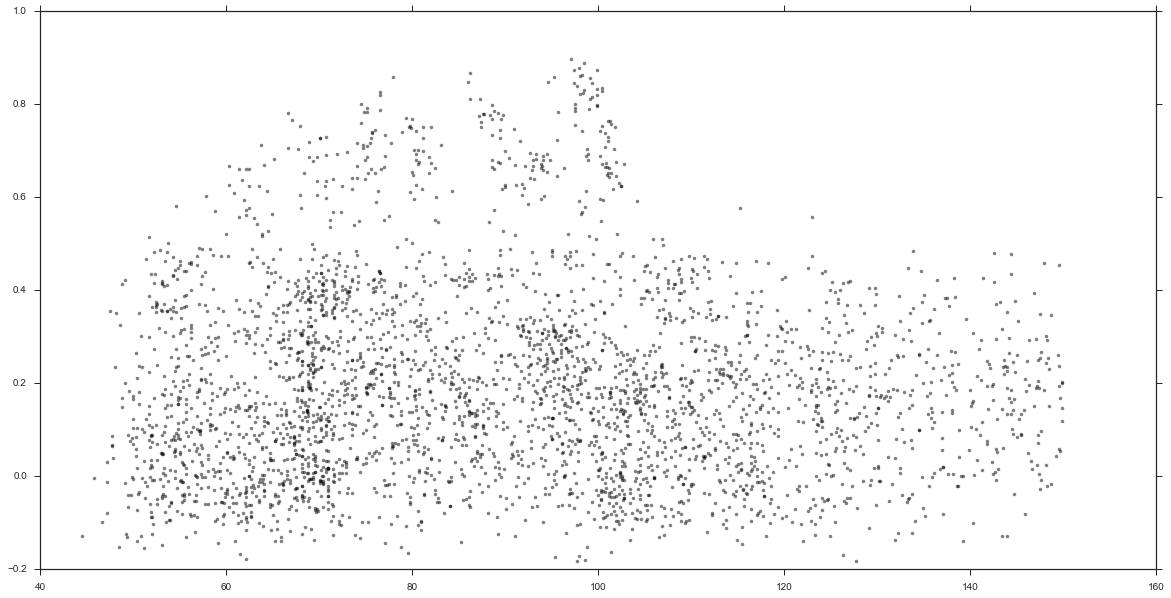

In [127]:
plt.figure(figsize = (20,10))
#plt.plot(np.arange(len(best_values)), best_values, 'k,', alpha = 0.5)
plt.plot(peri_list, best_values, 'k.', alpha = 0.5)

#plt.ylim(0.5,1)
plt.show()

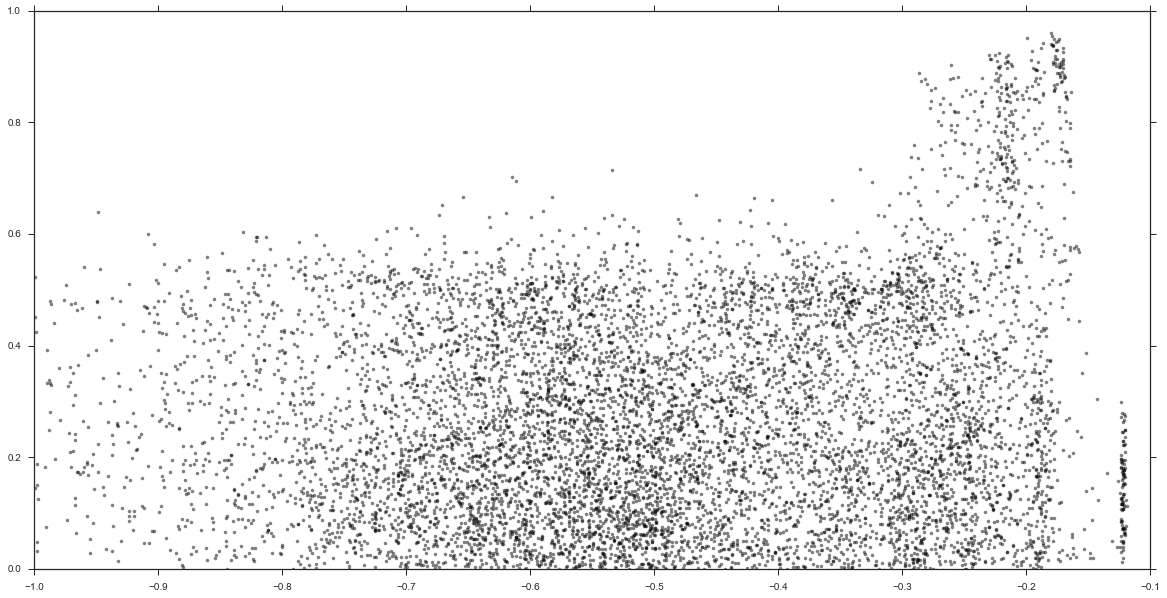

In [105]:
plt.figure(figsize = (20,10))
#plt.plot(np.arange(len(best_values)), best_values, 'k,', alpha = 0.5)
plt.plot(periarea_list, best_values, 'k.', alpha = 0.5)

plt.ylim(0,1)
#plt.xlim(-0.2, 0)
plt.show()

In [45]:
cv2.VIDEOWRITER_PROP_NSTRIPES

3

In [49]:
test_M

array([[ -1.38945470e+00,   5.76115362e-01,   2.93042773e+03],
       [ -4.80805312e-01,  -1.47675917e+00,   4.83391358e+03],
       [ -3.88761451e-04,  -5.20939322e-04,   1.00000000e+00]])

In [50]:
import math

In [59]:
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-1
 
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    #assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [60]:
print rotationMatrixToEulerAngles(test_M)

[ -5.20939275e-04   2.64411071e-04  -2.80845104e+00]


In [55]:
test_angle

162.15979856720608

In [12]:
np.unique(ID_list)

array([29, 30, 34, 35, 38, 43, 47, 50, 51, 54, 55, 58, 59])

In [45]:
tag1 = np.array([2]*15 + [1]*10).astype(np.float64)
tag2 = np.array([2]*20 + [1]*5).astype(np.float64)

In [46]:
tag1

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [47]:
tag2

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.])

In [48]:
import scipy.stats as sps

In [49]:
sps.pearsonr(tag1, tag2)

(0.61237243569579458, 0.0011389435144915914)

In [89]:
import pinpoint

In [90]:
pinpoint.__version__

'0.0.1'

In [91]:
pinpoint.__doi__

AttributeError: 'module' object has no attribute '__doi__'

In [97]:
len(set([0,255,1]) - set([255,0]))

1

In [99]:
set(np.unique([0,255]))

{0, 255}

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'